## What Skills Do You Need to Transition from Data Analyst to Data Scientist?

This section explores the skills needed to transition roles using global job postings. We will cover:

- The average number of skills required for Data Analyst and Data Scientist roles.
- Gap analysis comparing the skill sets of Data Analysts and Data Scientists.
- The most impactful skills on salary within these roles.

### Import Libraries

In [12]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.ensemble import RandomForestRegressor
import shap

### Load Cleaned Dataset

In [13]:
df = pd.read_pickle(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final_2.pkl')

### Number of Skills vs Number of Job Postings
Here we analyze how many skills are typically required for Data Analyst and Data Scientist roles. Understanding this helps to grasp the complexity and expectations for transitioning between these roles.

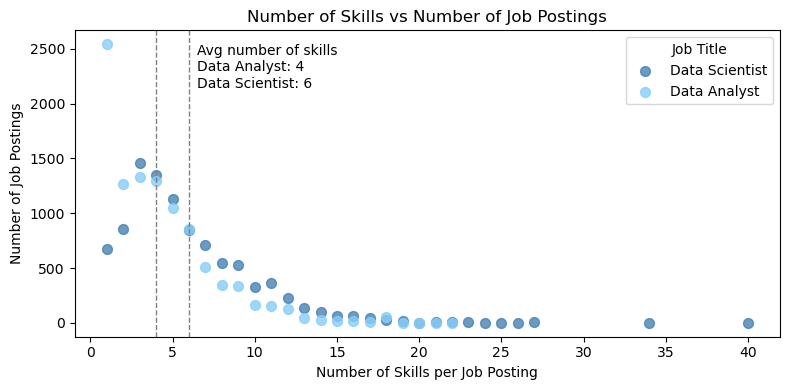

In [14]:
roles = ['Data Scientist', 'Data Analyst']
df_filtered = df[df['job_title_short'].isin(roles)].copy()

# Count skills
df_filtered['num_skills'] = df_filtered['job_skills'].apply(len)

# Group by job title and num_skills
grouped = (
    df_filtered.groupby(['job_title_short', 'num_skills'])
    .size()
    .reset_index(name='num_postings')
)

# Mean skills per role
mean_skills = df_filtered.groupby('job_title_short')['num_skills'].mean().round(0).astype(int)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

colors = {'Data Scientist': 'steelblue', 'Data Analyst': 'lightskyblue'}

for role in roles:
    data = grouped[grouped['job_title_short'] == role]
    ax.scatter(
        data['num_skills'], 
        data['num_postings'], 
        label=role, 
        color=colors[role], 
        s=50, alpha=0.8
    )
    # Add vertical mean line
    ax.axvline(mean_skills[role], color="gray", linestyle="--", linewidth=1)

# Annotation box
avg_text = (
    f"Avg number of skills\n"
    f"Data Analyst: {mean_skills['Data Analyst']}\n"
    f"Data Scientist: {mean_skills['Data Scientist']}"
)
ax.text(
    max(mean_skills) + 0.5,
    grouped['num_postings'].max(),
    avg_text,
    ha='left',
    va='top'
)

# Labels and formatting
ax.set_title('Number of Skills vs Number of Job Postings')
ax.set_xlabel('Number of Skills per Job Posting')
ax.set_ylabel('Number of Job Postings')
ax.legend(title='Job Title')

plt.tight_layout()
plt.show()

Average number of skills needed to land **Data Analyst** role is **4** when for **Data Scientist** the number is **6**. Now we can find the most in-demand Data Analyst skills that could be useful for transition to Data Scientist role and skills that is needed to get additionally. 

### Skill Requirements for Transition: Skills You Should Have vs. Skills to Learn

We identify the top-4 most in-demand Data Analyst skills and the top-6 Data Scientist skills. By comparing these sets, we reveal which skills a job seeker should develop further and which new skills are needed to successfully transition into a Data Scientist role. As skills required for the role are developing during the time, we'll use the most fresh data - job postings from 2024.

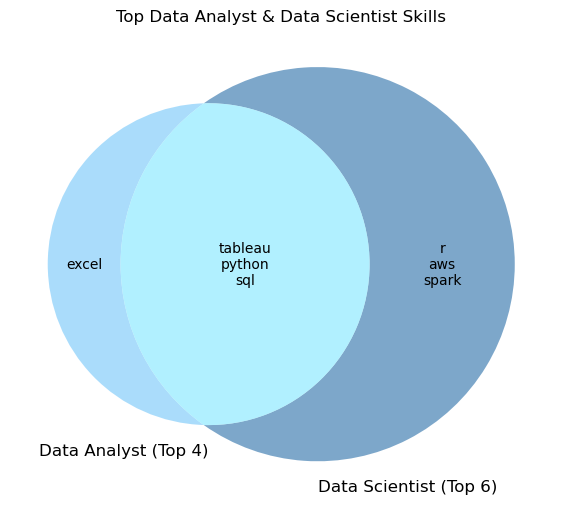

Optional to learn: ['sas', 'tensorflow', 'azure', 'pytorch']


In [15]:
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'], errors='coerce')
df_2024 = df[df['job_posted_date'].dt.year == 2024]

# Data Analyst: Top 4 skills in 2024
skills_da = df_2024[df_2024['job_title_short'] == 'Data Analyst']['job_skills']
skill_counts_da = {}
for skills in skills_da:
    if isinstance(skills, list):
        for skill in skills:
            skill_counts_da[skill] = skill_counts_da.get(skill, 0) + 1
top4_da = sorted(skill_counts_da, key=skill_counts_da.get, reverse=True)[:4]

# Data Scientist: Top 6 skills in 2024
skills_ds = df_2024[df_2024['job_title_short'] == 'Data Scientist']['job_skills']
skill_counts_ds = {}
for skills in skills_ds:
    if isinstance(skills, list):
        for skill in skills:
            skill_counts_ds[skill] = skill_counts_ds.get(skill, 0) + 1
top6_ds = sorted(skill_counts_ds, key=skill_counts_ds.get, reverse=True)[:6]

# Convert to sets for Venn diagram
set_da = set(top4_da)
set_ds = set(top6_ds)

# Plot Venn diagram
plt.figure(figsize=(7,7))
venn = venn2(
    [set_da, set_ds],
    set_labels=('Data Analyst (Top 4)', 'Data Scientist (Top 6)'),
    set_colors=('lightskyblue', 'steelblue'),
    alpha=0.7
)

# Annotate each section with skill names
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text('\n'.join(set_da - set_ds))
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text('\n'.join(set_ds - set_da))
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text('\n'.join(set_da & set_ds))

plt.title('Top Data Analyst & Data Scientist Skills')
plt.show()

top10_ds = sorted(skill_counts_ds, key=skill_counts_ds.get, reverse=True)[:10]
other_gap_skills = [skill for skill in top10_ds if skill not in top6_ds]

print('Optional to learn:', other_gap_skills)

The Venn diagram illustrates the overlap and differences between the top skills for Data Analysts and Data Scientists:

- **Python, SQL, and Tableau** are essential for both roles.
- Excel, fundamental for Data Analysts, is less important for Data Scientists, so no need develop this skill when you are looking for the transition.
- Instead focus on learning **R, Spark, and AWS** that'll help to sucseed Data Scientist role requirement.

Also take into account that you don't need focuse on Tableau if you as a Data Analyst aleady know Power BI or Looker as powerful data visualization tools. Moreover, optionaly you can choose SAS instead of R as statistical analysis tools, Azure instead of AWS as cloud platforms, Tensorflow or Pytorch instead of Spark that are more focuced ML and deeplearning than big data processing.

### Analyzing the Impact of Skills on Salary

To quantify how individual skills influence salary for Data Scientist roles, we perform the following:

1. Prepare the dataset by filtering roles and one-hot encoding the top skills.
2. Train a tree-based regression model (Random Forest) to estimate salaries.
3. Use SHAP values for interpretable feature importance.

In [16]:
df_ds = df_2024[df_2024['job_title_short'] == 'Data Scientist'].copy()

top10_skills = (
    pd.Series([skill for skills in df_ds['job_skills'] if skills for skill in skills])
    .value_counts()
    .head(10)
    .index
)

# One-hot encode top 10 skills
for skill in top10_skills:
    df_ds[skill] = df_ds['job_skills'].apply(lambda skills: int(skill in skills))

# Features & target
X = df_ds[top10_skills]
y = df_ds['salary_month_avg_eur']

df_ds.head(5)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,python,sql,r,tableau,spark,aws,sas,tensorflow,azure,pytorch
6,Data Scientist,Python Data Scientist/Analyst - LLM Project,Anywhere,via Jobgether,Full-time and Temp work,True,Algeria,2024-06-15,False,False,...,1,0,0,0,0,0,0,0,0,0
7,Data Scientist,Python Data Scientist/Analyst - LLM Project,Anywhere,Jobgether,Full-time,True,Algeria,2024-11-11,False,False,...,1,0,0,0,0,0,0,0,0,0
16,Data Scientist,Data Science Economic Research Manager,Argentina,via Ai-Jobs.net,Full-time,False,Argentina,2024-02-04,False,False,...,0,0,0,0,0,1,0,0,0,0
17,Data Scientist,Data Scientist Career,"Leandro N. Alem, Buenos Aires Province, Argentina",via Ai-Jobs.net,Full-time,False,Argentina,2024-03-01,False,False,...,1,0,0,0,0,0,0,0,0,0
18,Data Scientist,Python Data Scientist/Analyst,Anywhere,via Jobgether,Full-time,True,Argentina,2024-05-10,False,False,...,1,0,0,0,0,0,0,0,0,0


We train a Random Forest Regressor on the one-hot encoded skills and compute SHAP values to explain the model predictions.

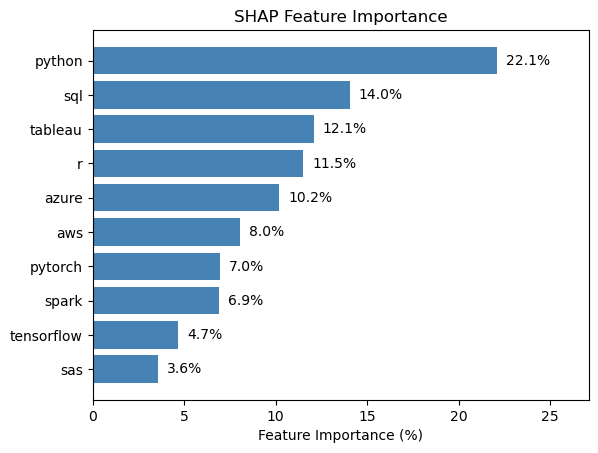

In [17]:
model = RandomForestRegressor(random_state=42).fit(X, y)
explainer = shap.TreeExplainer(model)
sv = explainer(X)

means = np.abs(sv.values).mean(0)
perc = means / means.sum() * 100
idx = np.argsort(means)[::-1]

plt.barh(np.array(X.columns)[idx], perc[idx], color="steelblue")
plt.gca().invert_yaxis()
plt.xlim(0, perc.max() + 5)

for i, v in enumerate(perc[idx]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')
plt.xlabel("Feature Importance (%)")
plt.title("SHAP Feature Importance")
plt.show()

SHAP feature importance for the Random Forest Regressor model predicting salaries shows skill’s contribution to the model’s predictions, expressed as a percentage of total importance. 
- Python (22.1%) has the largest impact on salary predictions.
- SQL, Tableau, and R follow as other high-impact skills.
- Skills like SAS and TensorFlow contribute less, but still play a role.

### Summary:

This analysis explored the skill requirements for transitioning from **Data Analyst** to **Data Scientist** roles.

- On average, Data Scientists require about 6 skills per job posting, while Data Analysts require about 4.
- The common top skills for Data Analysts and Data Scientists are SQL, Python and Tableau. These skills are also the most impactful on salary. 
- To transition successfully, Data Analysts should close the skill gap with Data Scientist requirements, focusing on learning AWS, Spark, and R, or similar tools.
  
The next notebook will leverage this list of impactful skills to build predictive model for salary estimation.